In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from collections import Counter

# NLP and Text Processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import cmudict
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# Local
from classes.song import Song
from classes.spotify_manager import SpotifyManager
from classes.lyrics_manager import LyricsManager
from classes.utils import gather_data_from_folders
from classes.model_pipeline import OptimalRegressionPipeline, OptimalClassificationPipeline
from classes.baseline_models import MeanBaselineModel, MajorityBaselineModel, RandomBaselineModel

import warnings
warnings.simplefilter('ignore')
load_dotenv();

In [3]:
df = pd.read_pickle(os.path.join('datasets', "new_data.pkl"))
print(f"Loaded {df.shape[0]} songs")
df.head()

Loaded 3621 songs


,id,title,artist,album_art_url,popularity,explicit,album_release_year,duration_ms,genres,lyrics,...,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99,genre
0,6YDDrg8llsRtAgLlIROzZc,put your head on my shoulder,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,68.0,0,1959,158906,"['genre:pop', 'adult', 'standards', 'canadian'...",Put your head on my shoulder\nHold me in your ...,...,-0.003423,0.016568,0.002319,0.007630,-0.003030,0.009287,0.006670,0.003556,0.003469,pop
1,5zvOXJrzzUlvXwyuwZ0toZ,oh! carol,neil sedaka,https://i.scdn.co/image/ab67616d0000b2733843b4...,58.0,0,1959,136562,"['genre:pop', 'adult', 'standards', 'brill', '...","Oh! Carol\nI am but a fool\nDarling, I love yo...",...,-0.004206,-0.010597,0.007079,-0.003365,0.015292,-0.004908,0.000558,-0.006474,0.000418,pop
2,0QGwOFQChzflLAmPq5NwKo,a teenager in love,dion & the belmonts,https://i.scdn.co/image/ab67616d0000b2737a6091...,61.0,0,1959,158253,"['genre:pop', 'brill', 'building', 'pop', 'doo...",Each time we have a quarrel\nIt almost breaks ...,...,-0.005288,-0.016978,0.001973,0.016645,0.005722,-0.000172,0.000788,-0.002016,0.009753,pop
3,0hjYuU2Z9jcKvOl39oUpeE,diana,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,56.0,0,1959,147760,"['genre:pop', 'adult', 'standards', 'canadian'...","I'm so young and you're so old\nThis, my darli...",...,-0.002524,-0.011046,-0.001598,-0.004006,0.001692,0.002618,0.004807,-0.001807,-0.000070,pop
4,1mdfrHeZzxjz0FJ4BKRuxS,puppy love,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,57.0,0,1959,161533,"['genre:pop', 'adult', 'standards', 'canadian'...",And they called it puppy love\nOh I guess they...,...,-0.005602,0.010182,-0.006879,-0.001400,-0.001735,-0.001136,-0.004035,0.016890,0.001792,pop


In [4]:
df.head()

,id,title,artist,album_art_url,popularity,explicit,album_release_year,duration_ms,genres,lyrics,...,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99,genre
0,6YDDrg8llsRtAgLlIROzZc,put your head on my shoulder,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,68.0,0,1959,158906,"['genre:pop', 'adult', 'standards', 'canadian'...",Put your head on my shoulder\nHold me in your ...,...,-0.003423,0.016568,0.002319,0.007630,-0.003030,0.009287,0.006670,0.003556,0.003469,pop
1,5zvOXJrzzUlvXwyuwZ0toZ,oh! carol,neil sedaka,https://i.scdn.co/image/ab67616d0000b2733843b4...,58.0,0,1959,136562,"['genre:pop', 'adult', 'standards', 'brill', '...","Oh! Carol\nI am but a fool\nDarling, I love yo...",...,-0.004206,-0.010597,0.007079,-0.003365,0.015292,-0.004908,0.000558,-0.006474,0.000418,pop
2,0QGwOFQChzflLAmPq5NwKo,a teenager in love,dion & the belmonts,https://i.scdn.co/image/ab67616d0000b2737a6091...,61.0,0,1959,158253,"['genre:pop', 'brill', 'building', 'pop', 'doo...",Each time we have a quarrel\nIt almost breaks ...,...,-0.005288,-0.016978,0.001973,0.016645,0.005722,-0.000172,0.000788,-0.002016,0.009753,pop
3,0hjYuU2Z9jcKvOl39oUpeE,diana,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,56.0,0,1959,147760,"['genre:pop', 'adult', 'standards', 'canadian'...","I'm so young and you're so old\nThis, my darli...",...,-0.002524,-0.011046,-0.001598,-0.004006,0.001692,0.002618,0.004807,-0.001807,-0.000070,pop
4,1mdfrHeZzxjz0FJ4BKRuxS,puppy love,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,57.0,0,1959,161533,"['genre:pop', 'adult', 'standards', 'canadian'...",And they called it puppy love\nOh I guess they...,...,-0.005602,0.010182,-0.006879,-0.001400,-0.001735,-0.001136,-0.004035,0.016890,0.001792,pop


In [5]:
spotify_features = ['popularity', 'explicit',
       'album_release_year', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature']

lyrics_features = ['unique_word_count', 'noun_ratio',
       'verb_ratio', 'repetition_count', 'language', 'genre',
       'lexical_richness', 'semantic_depth', 'syntactic_complexity',
       'rhyme_density',  'linguistic_uniqueness', 'flesch_reading_ease', 
       'gunning_fog', 'dale_chall', 'type_token_ratio', 'word_count',
       'sentiment_polarity', 'sentiment_subjectivity', 'vader_compound', 'sentiment_variability']

tfidf_features = [ f for f in df.columns if f.startswith("tfidf_") ]

w2v_features = [ f for f in df.columns if f.startswith("w2v") ]

empath_features = [ f for f in df.columns if f.startswith("empath") ]

audio_extracted_features = ['mfcc_1', 'mfcc_2',
       'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
       'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8',
       'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'spectral_contrast_1', 'spectral_contrast_2', 'spectral_contrast_3',
       'spectral_contrast_4', 'spectral_contrast_5', 'spectral_contrast_6',
       'spectral_contrast_7', 'tempo_extracted', 'zcr']


---

# Classification

<Axes: xlabel='genre'>

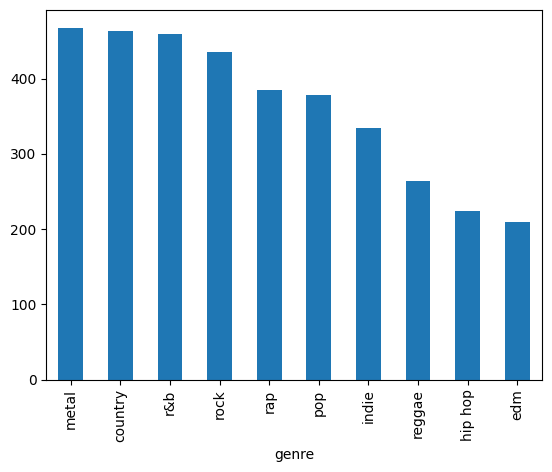

In [8]:
df.genre.value_counts().plot(kind='bar')

## Prediction with all features

In [9]:
target = 'genre'
features = [ f for f in spotify_features + lyrics_features + tfidf_features + w2v_features + empath_features + audio_extracted_features if f in df.columns ]

In [10]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [11]:
cat_features

['explicit', 'key', 'mode', 'time_signature', 'language']

In [12]:
len(num_features)

458

In [13]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=20,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: genre
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['valence',
                                                                    'speechiness',
                                                                    'w2v_82',
                                                                    'tfidf_82',
                                                                    'tfidf_2',
                                                                    'w2v_73',
                                                                    'empath_economics',
                                                                    'empath_celebration',
                                                                    'chroma_2',
                                                                    'empath_anger',
                                                                    't...
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['mode',
                                                                    'time_signature',
                                                                    'key',
                                                                    'language',
                                                                    'explicit'])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x71c3043c6830>)])

In [14]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-21 03:35:06,050] A new study created in memory with name: catboost_genre

KeyboardInterrupt

[I 2024-12-21 04:05:01,153] Trial 3 finished with value: 0.6120079369167818 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.05511450906007513, 'l2_leaf_reg': 5.007791975010825}. Best is trial 3 with value: 0.6120079369167818.
[I 2024-12-21 04:05:21,914] Trial 0 finished with value: 0.6113003086237656 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.07128442747894019, 'l2_leaf_reg': 8.767375388399248}. Best is trial 3 with value: 0.6120079369167818.
[I 2024-12-21 04:05:37,644] Trial 5 finished with value: 0.6128505714056864 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.0572717618749261, 'l2_leaf_reg': 8.299710147490934}. Best is trial 5 with value: 0.6128505714056864.
[I 2024-12-21 04:06:33,457] Trial 2 finished with value: 0.6047187846601993 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.027790700978097

In [ ]:
pipeline.model.training_results

In [ ]:
pipeline.evaluate_model()

In [ ]:
pipeline.perform_shap_analysis()

## Prediction with lyrics

In [ ]:
target = 'genre'
features = [ f for f in lyrics_features + tfidf_features + w2v_features + empath_features if f in df.columns ]

In [ ]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [ ]:
cat_features

In [ ]:
len(num_features)

In [ ]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=20,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

In [ ]:
pipeline.split()
pipeline.train_model()

In [ ]:
pipeline.model.training_results

In [ ]:
pipeline.evaluate_model()

In [ ]:
pipeline.perform_shap_analysis()

## Prediction with Spotify Features

In [ ]:
target = 'genre'
features = [ f for f in spotify_features if f in df.columns ]

In [ ]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [ ]:
cat_features

In [ ]:
len(num_features)

In [ ]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

In [ ]:
pipeline.split()
pipeline.train_model()

In [ ]:
pipeline.model.training_results

In [ ]:
pipeline.evaluate_model()

In [ ]:
pipeline.perform_shap_analysis()

## Prediction with Audio Features

In [ ]:
target = 'genre'
features = [ f for f in audio_extracted_features if f in df.columns ]

In [ ]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [ ]:
cat_features

In [ ]:
len(num_features)

In [ ]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

In [ ]:
pipeline.split()
pipeline.train_model()

In [ ]:
pipeline.model.training_results

In [ ]:
pipeline.evaluate_model()

In [ ]:
pipeline.perform_shap_analysis()

## Baseline

In [ ]:
majority_model = MajorityBaselineModel()
majority_model.fit(pipeline.X_train, pipeline.y_train)
y_pred = majority_model.predict(pipeline.X_test)
majority_model.evaluate(pipeline.y_test, y_pred)

In [ ]:
random_model = RandomBaselineModel()
random_model.fit(pipeline.X_train, pipeline.y_train)
y_pred = random_model.predict(pipeline.X_test)
random_model.evaluate(pipeline.y_test, y_pred)